**About the Competition:**

[Avito](https://www.avito.ru/), Russia’s largest classified advertisements website, is hosting its fourth Kaggle competition. The challenge is to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. 

**About the Notebook:**

One more exciting competition ahead and this involves both NLP (text data in Russian) and Image data along with numerical . In this notebook, let us get into the basic data exploration using python. 

Thanks to [Yandex Translate](https://translate.yandex.com/), I was able to get english names for the russian names and used them whenever possible. Most of the plots are in plotly and so please hover over them to see more details. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Now let us look at the input files present in the dataset. 

In [2]:
#from subprocess import check_output
#print(check_output(["ls", "../input/"]).decode("utf8"))

The description of the data files from the data page:

* train.csv - Train data.
* test.csv - Test data. Same schema as the train data, minus deal_probability.
* train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.
* test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.
* periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
* periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.
* train_jpg.zip - Images from the ads in train.csv.
* test_jpg.zip - Images from the ads in test.csv.
* sample_submission.csv - A sample submission in the correct format.

Let us start with the train file.

In [2]:
train_df = pd.read_csv("./data/train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("./data/test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)

Train file rows and columns are :  (1503424, 18)
Test file rows and columns are :  (508438, 17)


In [3]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


The train dataset description is as follows:

* item_id - Ad id.
* user_id - User id.
* region - Ad region.
* city - Ad city.
* parent_category_name - Top level ad category as classified by Avito's ad model.
* category_name - Fine grain ad category as classified by Avito's ad model.
* param_1 - Optional parameter from Avito's ad model.
* param_2 - Optional parameter from Avito's ad model.
* param_3 - Optional parameter from Avito's ad model.
* title - Ad title.
* description - Ad description.
* price - Ad price.
* item_seq_number - Ad sequential number for user.
* activation_date- Date ad was placed.
* user_type - User type.
* image - Id code of image. Ties to a jpg file in train_jpg. Not every ad has an image.
* image_top_1 - Avito's classification code for the image.
* deal_probability - The target variable. This is the likelihood that an ad actually sold something. It's not possible to verify every transaction with certainty, so this column's value can be any float from zero to one.

So deal probability is our target variable and  is a float value between 0 and 1 as per the data page. Let us have a look at it. 

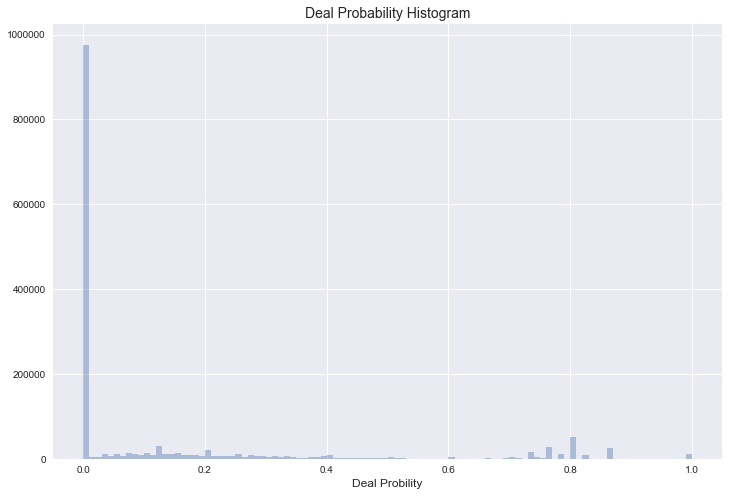

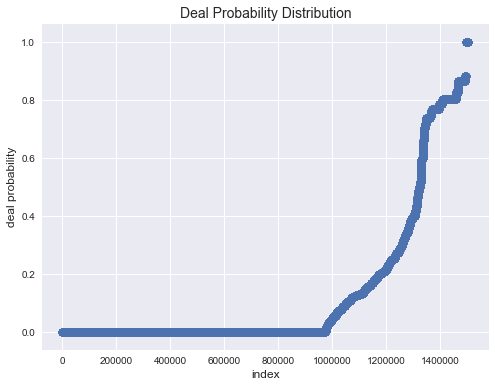

In [4]:
plt.figure(figsize=(12,8))
sns.distplot(train_df["deal_probability"].values, bins=100, kde=False)
plt.xlabel('Deal Probility', fontsize=12)
plt.title("Deal Probability Histogram", fontsize=14)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df['deal_probability'].values))
plt.xlabel('index', fontsize=12)
plt.ylabel('deal probability', fontsize=12)
plt.title("Deal Probability Distribution", fontsize=14)
plt.show()

So almost 100K Ads has 0 probaility (which means it did not sell anything) and few ads have a probability of 1. Rest of the deal probabilities have values in between. 

**Region wise distribution of Ads:**

Let us look at the region wise distribution of ads. 

In [5]:
from io import StringIO

temp_data = StringIO("""
region,region_en
Свердловская область, Sverdlovsk oblast
Самарская область, Samara oblast
Ростовская область, Rostov oblast
Татарстан, Tatarstan
Волгоградская область, Volgograd oblast
Нижегородская область, Nizhny Novgorod oblast
Пермский край, Perm Krai
Оренбургская область, Orenburg oblast
Ханты-Мансийский АО, Khanty-Mansi Autonomous Okrug
Тюменская область, Tyumen oblast
Башкортостан, Bashkortostan
Краснодарский край, Krasnodar Krai
Новосибирская область, Novosibirsk oblast
Омская область, Omsk oblast
Белгородская область, Belgorod oblast
Челябинская область, Chelyabinsk oblast
Воронежская область, Voronezh oblast
Кемеровская область, Kemerovo oblast
Саратовская область, Saratov oblast
Владимирская область, Vladimir oblast
Калининградская область, Kaliningrad oblast
Красноярский край, Krasnoyarsk Krai
Ярославская область, Yaroslavl oblast
Удмуртия, Udmurtia
Алтайский край, Altai Krai
Иркутская область, Irkutsk oblast
Ставропольский край, Stavropol Krai
Тульская область, Tula oblast
""")

region_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, region_df, how="left", on="region")

In [6]:
temp_series = train_df['region_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Region distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="region")

The regions have percentage of ads between 1.71% to 9.41%. So the top regions are:
1. Krasnodar region - 9.41%
2. Sverdlovsk region - 6.28%
3. Rostov region - 5.99%


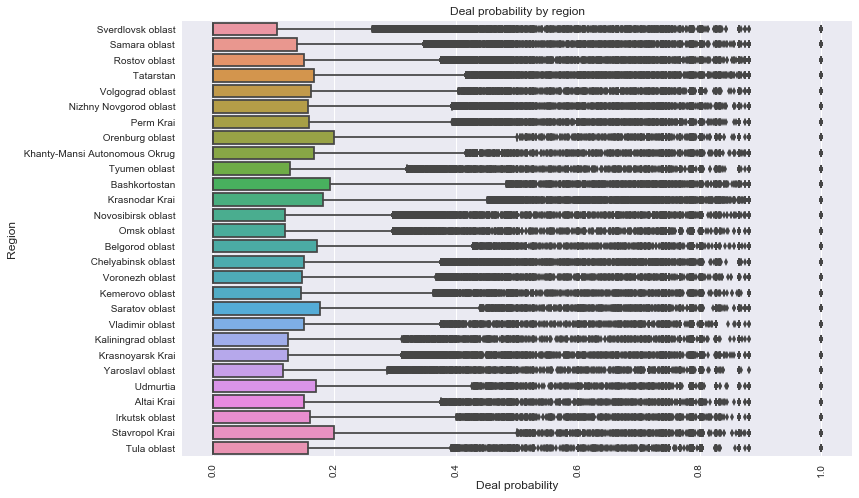

In [7]:
plt.figure(figsize=(12,8))
sns.boxplot(y="region_en", x="deal_probability", data=train_df)
plt.xlabel('Deal probability', fontsize=12)
plt.ylabel('Region', fontsize=12)
plt.title("Deal probability by region")
plt.xticks(rotation='vertical')
plt.show()

**City wise distribution of Ads:**

Now let us have a look at the top 20 cities present in the dataset.

In [8]:
cnt_srs = train_df['city'].value_counts().head(20)
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='City distribution of Ads',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CityAds")

So the top cities where the ads are shown are
1. Krasnodar
2. Ekaterinburg
3. Novosibirsk

**Parent Category Name:**

Now let us look at the distribution of parent cateory names.

In [9]:
temp_data = StringIO("""
parent_category_name,parent_category_name_en
Личные вещи,Personal belongings
Для дома и дачи,For the home and garden
Бытовая электроника,Consumer electronics
Недвижимость,Real estate
Хобби и отдых,Hobbies & leisure
Транспорт,Transport
Услуги,Services
Животные,Animals
Для бизнеса,For business
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="parent_category_name", how="left")

In [10]:
temp_series = train_df['parent_category_name_en'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Parent Category distribution',
    width=900,
    height=900,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="parentcategory")

1So 46.4% of the ads are for Personal belongings, 11.9% are for home and garden and 11.5% for consumer electronics.

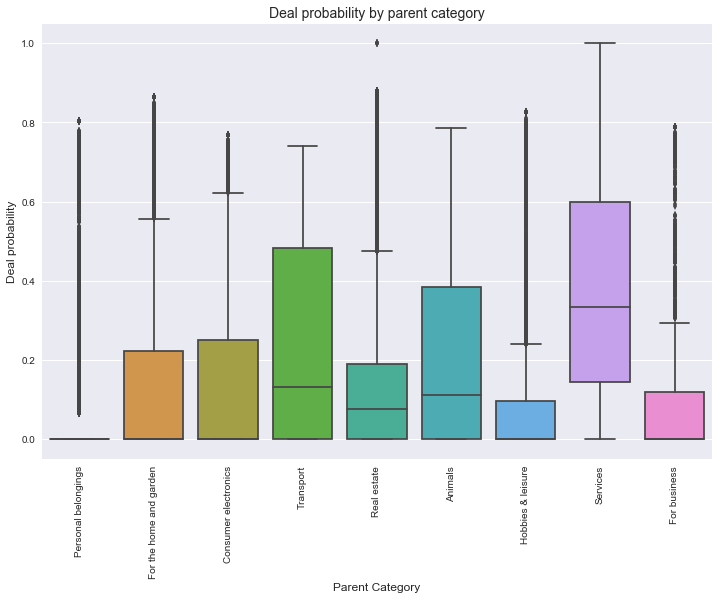

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(x="parent_category_name_en", y="deal_probability", data=train_df)
plt.ylabel('Deal probability', fontsize=12)
plt.xlabel('Parent Category', fontsize=12)
plt.title("Deal probability by parent category", fontsize=14)
plt.xticks(rotation='vertical')
plt.show()

Services category seems to have slightly higher deal probability compared to others. 

** Category of Ads:**

Now let us look at the category of ads.

In [12]:
temp_data = StringIO("""
category_name,category_name_en
"Одежда, обувь, аксессуары","Clothing, shoes, accessories"
Детская одежда и обувь,Children's clothing and shoes
Товары для детей и игрушки,Children's products and toys
Квартиры,Apartments
Телефоны,Phones
Мебель и интерьер,Furniture and interior
Предложение услуг,Offer services
Автомобили,Cars
Ремонт и строительство,Repair and construction
Бытовая техника,Appliances
Товары для компьютера,Products for computer
"Дома, дачи, коттеджи","Houses, villas, cottages"
Красота и здоровье,Health and beauty
Аудио и видео,Audio and video
Спорт и отдых,Sports and recreation
Коллекционирование,Collecting
Оборудование для бизнеса,Equipment for business
Земельные участки,Land
Часы и украшения,Watches and jewelry
Книги и журналы,Books and magazines
Собаки,Dogs
"Игры, приставки и программы","Games, consoles and software"
Другие животные,Other animals
Велосипеды,Bikes
Ноутбуки,Laptops
Кошки,Cats
Грузовики и спецтехника,Trucks and buses
Посуда и товары для кухни,Tableware and goods for kitchen
Растения,Plants
Планшеты и электронные книги,Tablets and e-books
Товары для животных,Pet products
Комнаты,Room
Фототехника,Photo
Коммерческая недвижимость,Commercial property
Гаражи и машиноместа,Garages and Parking spaces
Музыкальные инструменты,Musical instruments
Оргтехника и расходники,Office equipment and consumables
Птицы,Birds
Продукты питания,Food
Мотоциклы и мототехника,Motorcycles and bikes
Настольные компьютеры,Desktop computers
Аквариум,Aquarium
Охота и рыбалка,Hunting and fishing
Билеты и путешествия,Tickets and travel
Водный транспорт,Water transport
Готовый бизнес,Ready business
Недвижимость за рубежом,Property abroad
""")

temp_df = pd.read_csv(temp_data)
train_df = pd.merge(train_df, temp_df, on="category_name", how="left")

In [13]:
cnt_srs = train_df['category_name_en'].value_counts()
trace = go.Bar(
    y=cnt_srs.index[::-1],
    x=cnt_srs.values[::-1],
    orientation = 'h',
    marker=dict(
        color=cnt_srs.values[::-1],
        colorscale = 'Blues',
        reversescale = True
    ),
)

layout = dict(
    title='Category Name of Ads - Count',
    height=900
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="category name")

So the top 3 categories are:
1. Clothes, shoes, accessories
2. Children's clothing and footwear
3. Goods for children and toys


** User Type:**

Now let us look at the user type. 

In [14]:
temp_series = train_df['user_type'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='User Type distribution',
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

Private users constitute 72% of the data followed by company and shop.

**Price:**

This is the price shown in the Ad. 

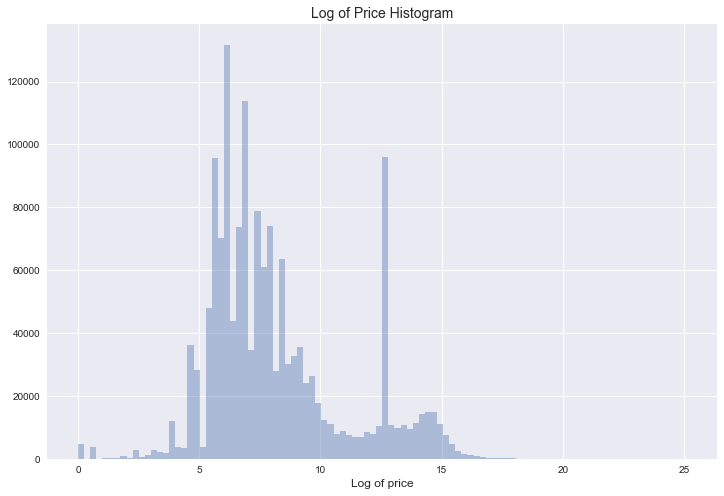

In [15]:
train_df["price_new"] = train_df["price"].values
train_df["price_new"].fillna(np.nanmean(train_df["price"].values), inplace=True)

plt.figure(figsize=(12,8))
sns.distplot(np.log1p(train_df["price_new"].values), bins=100, kde=False)
plt.xlabel('Log of price', fontsize=12)
plt.title("Log of Price Histogram", fontsize=14)
plt.show()

**Activation Date:**

In [16]:
cnt_srs = train_df['activation_date'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Train'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

# Activation dates in test
cnt_srs = test_df['activation_date'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color=cnt_srs.values,
        colorscale = 'Picnic',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Activation Dates in Test'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivationDate")

Inferences:

1. So the dates are not different between train and test sets. So we need to be careful while doing our validation. May be time based validation is a good option.
2. We are given two weeks data for training (March 15 to March 28) and one week data for testing (April 12 to April 18, 2017).
3. There is a gap of two weeks in between training and testing data. 
4. We can probably use weekday as a feature since all the days are present in both train and test sets. 


**User id:**

Now we can have a look at the number of unique users in train & test and also the number of common users if any.

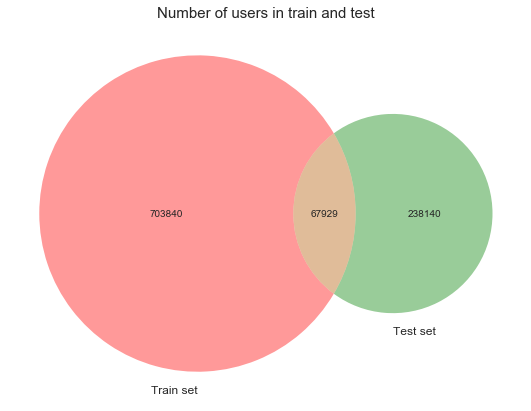

In [18]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(train_df.user_id.unique()), set(test_df.user_id.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of users in train and test", fontsize=15)
plt.show()

So out of the 306K users in test, about 68K users are there in train and the rest are new.

** Title: **

First let us look at the number of common titles between train and test set

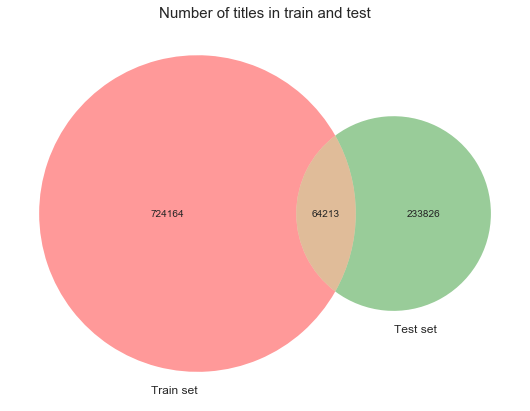

In [19]:
from matplotlib_venn import venn2

plt.figure(figsize=(10,7))
venn2([set(train_df.title.unique()), set(test_df.title.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Number of titles in train and test", fontsize=15)
plt.show()

We have around 64K common titles between train and test set. Now let us look at the number of words present in the title column.

In [20]:
train_df["title_nwords"] = train_df["title"].apply(lambda x: len(x.split()))
test_df["title_nwords"] = test_df["title"].apply(lambda x: len(x.split()))

cnt_srs = train_df['title_nwords'].value_counts()

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in title column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="title_nwords")           

Majority of the tiles have 1, 2 or 3 words and has a long tail.

Now we will do the following:
1. Take the TF-IDF of the title column and this will be a sparse matrix with huge dimesnions.
2. Get the top SVD components fof this TF-IDF 
3. Plot the distribution of SVD components with Deal probability to see if these variables help.

In [21]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1))
full_tfidf = tfidf_vec.fit_transform(train_df['title'].values.tolist() + test_df['title'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['title'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['title'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_title_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

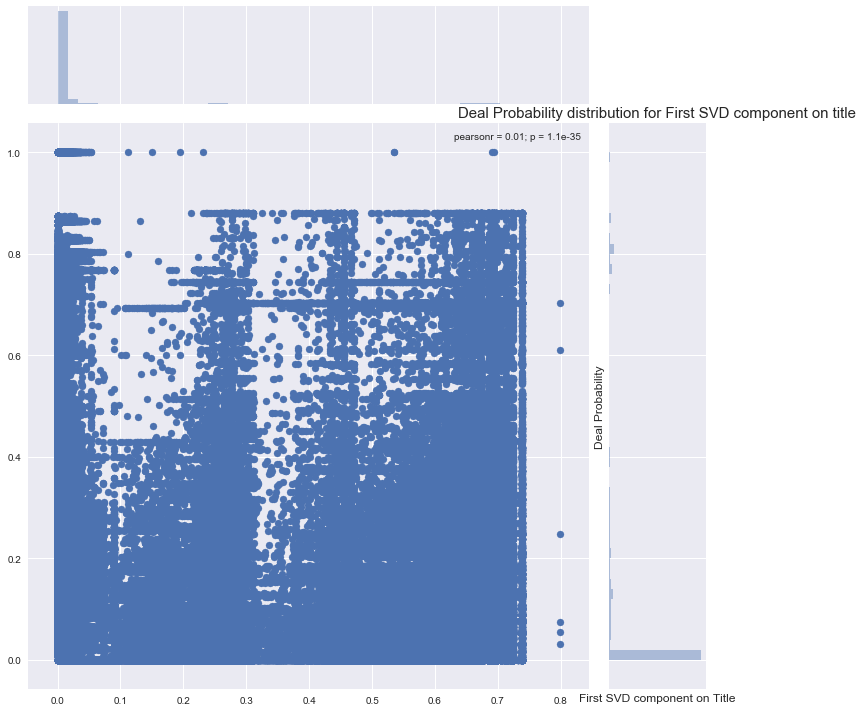

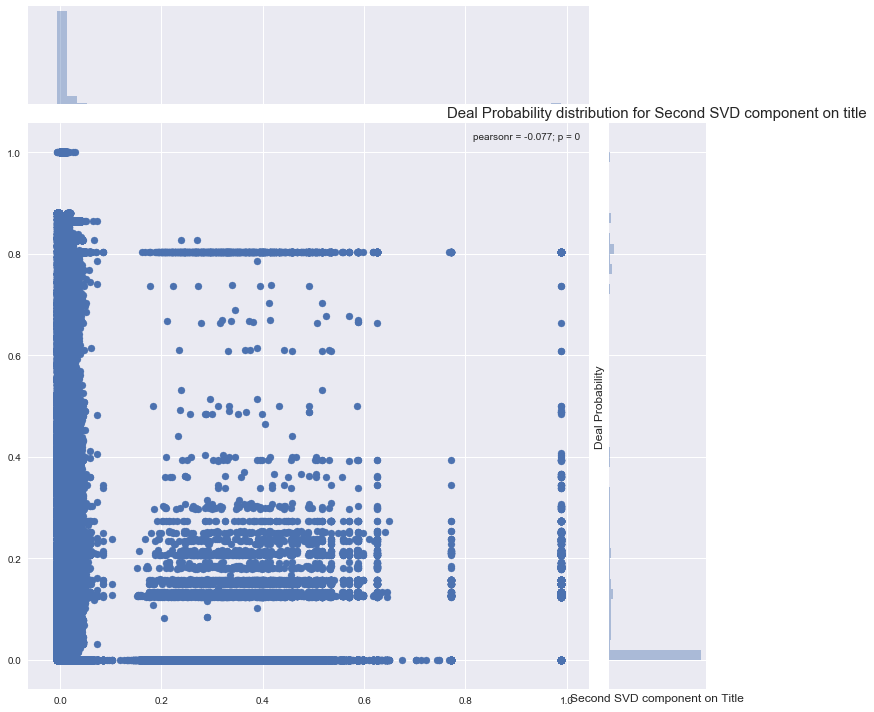

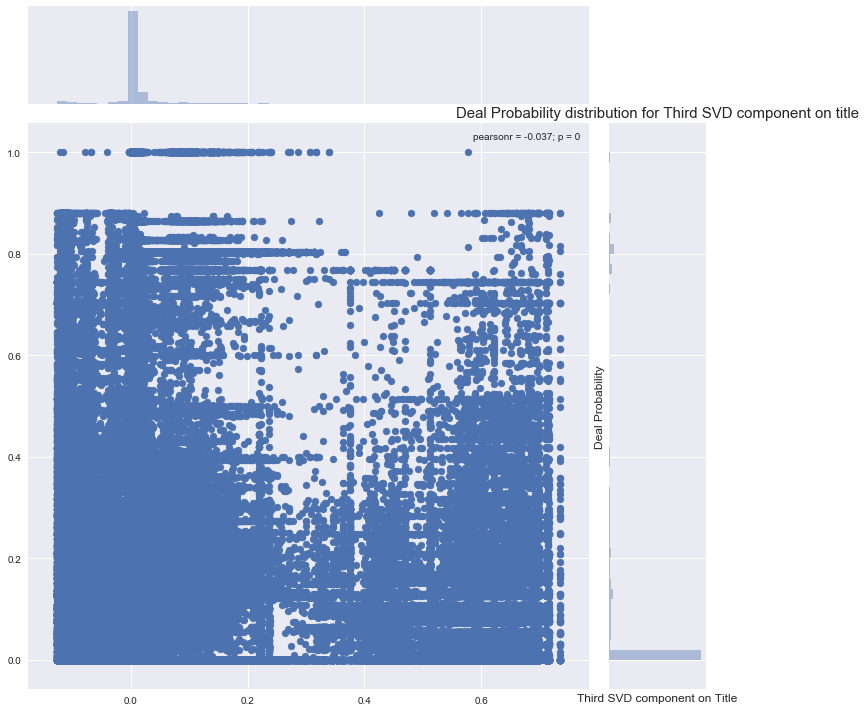

In [22]:
# 1st svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on title", fontsize=15)
plt.show()

# 2nd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

# 3rd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_title_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Third SVD component on Title', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on title", fontsize=15)
plt.show()

As we can see, the top SVD components capture quite an amount of variation in the data. So this might be helpful features in our modeling process.

**Description:**

Let us first check the number of words in the description column.


In [23]:
## Filling missing values ##
train_df["description"].fillna("NA", inplace=True)
test_df["description"].fillna("NA", inplace=True)

train_df["desc_nwords"] = train_df["description"].apply(lambda x: len(x.split()))
test_df["desc_nwords"] = test_df["description"].apply(lambda x: len(x.split()))

cnt_srs = train_df['desc_nwords'].value_counts().head(100)

trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    marker=dict(
        color="blue",
        #colorscale = 'Blues',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Number of words in Description column'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="desc_nwords")  

Description column has a huge right tail till about 700 words. I have cut the same till top 100 for better visualization.

Now let us create the first 3 SVD components for description column (just like title) and plot the same against deal probability.

In [24]:
### TFIDF Vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,1), max_features=100000)
full_tfidf = tfidf_vec.fit_transform(train_df['description'].values.tolist() + test_df['description'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['description'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['description'].values.tolist())

### SVD Components ###
n_comp = 3
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
train_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
test_svd.columns = ['svd_desc_'+str(i+1) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

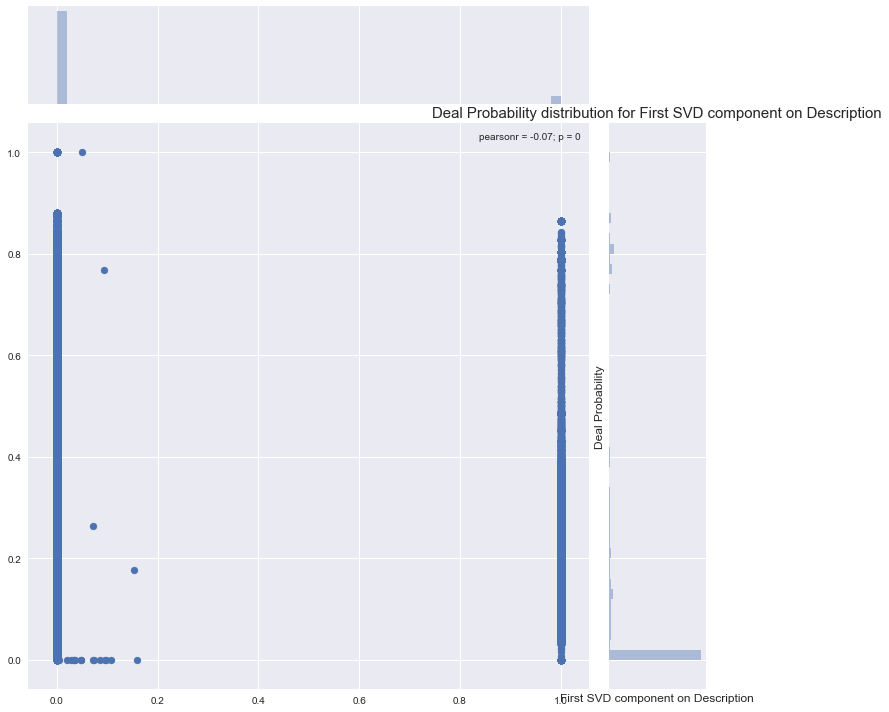

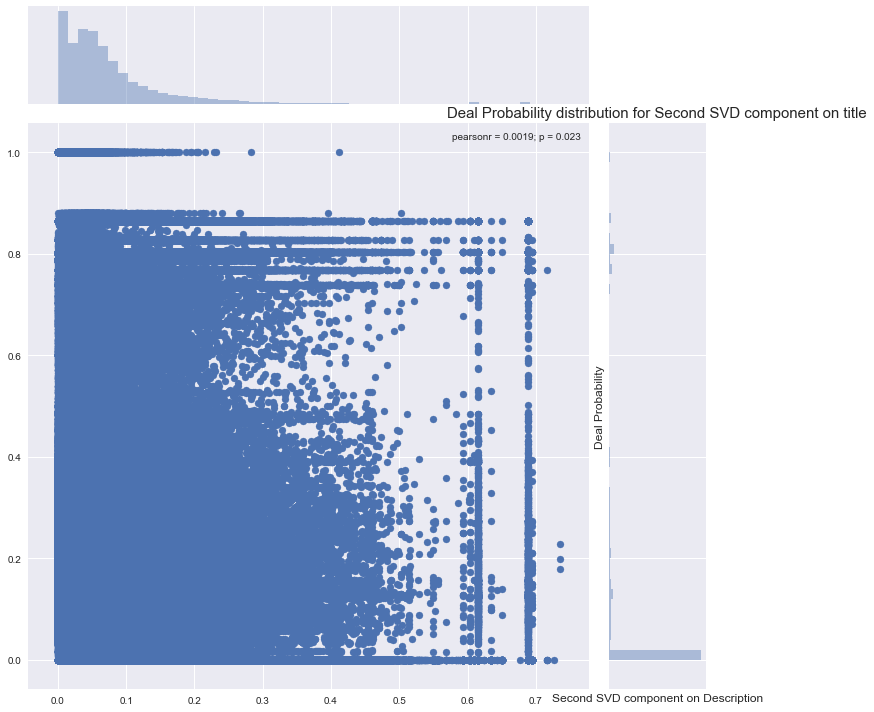

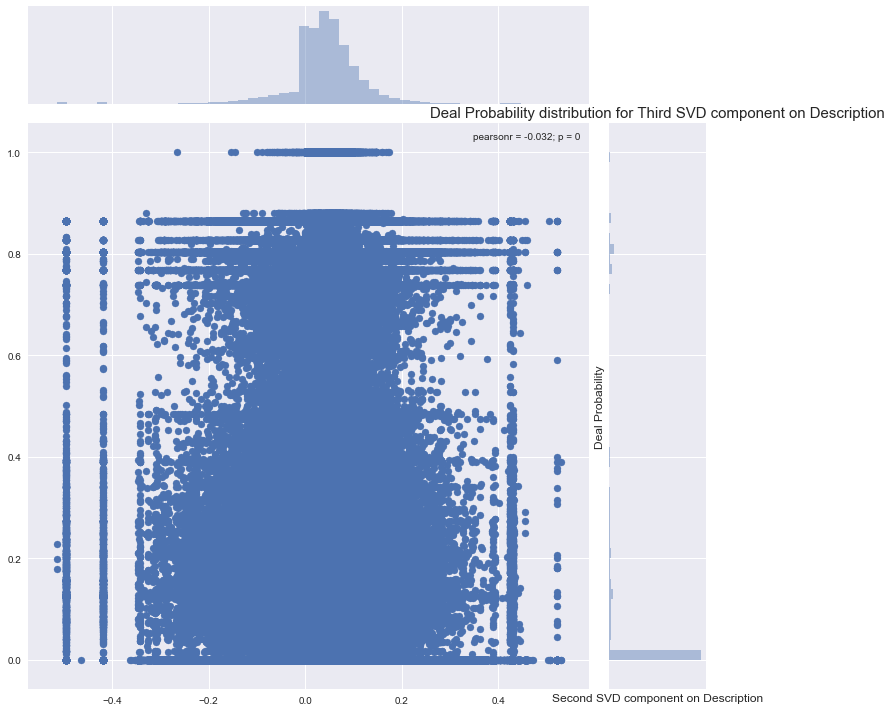

In [25]:
# 1st svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_1"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('First SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for First SVD component on Description", fontsize=15)
plt.show()

# 2nd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_2"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Second SVD component on title", fontsize=15)
plt.show()

# 3rd svd comp #
plt.figure(figsize=(8,8))
sns.jointplot(x=train_df["svd_desc_3"].values, y=train_df["deal_probability"].values, size=10)
plt.ylabel('Deal Probability', fontsize=12)
plt.xlabel('Second SVD component on Description', fontsize=12)
plt.title("Deal Probability distribution for Third SVD component on Description", fontsize=15)
plt.show()

Looks like it also captures some good amount of variability. 

** Baseline Model:**

Now let us build a baseline model using the given features and newly created features.

In the following block, we will do :
 1. Create a new feature for week day
 2. Label encode the cateforical variables
 3. Drop the columns that are not needed in the model.

In [32]:
# Target and ID variables #
train_y = train_df["deal_probability"].values
test_id = test_df["item_id"].values

# New variable on weekday #
train_df["activation_weekday"] = train_df["activation_date"].dt.weekday
test_df["activation_weekday"] = test_df["activation_date"].dt.weekday

# Label encode the categorical variables #
cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type", "param_1", "param_2", "param_3"]
for col in cat_vars:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

cols_to_drop = ["item_id", "user_id", "title", "description", "activation_date", "image", "svd_title_1", "svd_title_2", "svd_title_3", "svd_desc_1", "svd_desc_2", "svd_desc_3"]
train_X = train_df.drop(cols_to_drop + ["region_en", "parent_category_name_en", "category_name_en", "price_new", "deal_probability"], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

Now let us create a custom function to build the LightGBM model.

In [34]:
train_X.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,price,item_seq_number,user_type,image_top_1,title_nwords,desc_nwords,activation_weekday
0,11,1156,4,37,167,16,244,400.0,2,1,1008.0,3,7,1
1,9,352,2,15,27,16,244,3000.0,19,1,692.0,3,7,6
2,8,325,0,12,355,16,244,4000.0,9,1,3032.0,2,17,0
3,14,1698,4,37,304,16,244,2200.0,286,0,796.0,1,3,5
4,22,996,6,0,199,29,678,40000.0,3,1,2264.0,3,4,3


In [37]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 10000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

We will now split the train into development and validation sample and build our models. We will take the last 200K rows as validation sample. 

In [38]:
# Splitting the data for model training#
dev_X = train_X.iloc[:-200000,:]
val_X = train_X.iloc[-200000:,:]
dev_y = train_y[:-200000]
val_y = train_y[-200000:]
print(dev_X.shape, val_X.shape, test_X.shape)

# Training the model #
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

# Making a submission file #
pred_test[pred_test>1] = 1
pred_test[pred_test<0] = 0
sub_df = pd.DataFrame({"item_id":test_id})
sub_df["deal_probability"] = pred_test
sub_df.to_csv("baseline_lgb.csv", index=False)

(1303424, 14) (200000, 14) (508438, 14)
Training until validation scores don't improve for 100 rounds.
[20]	valid_0's rmse: 0.240013
[40]	valid_0's rmse: 0.235129
[60]	valid_0's rmse: 0.233209
[80]	valid_0's rmse: 0.232276
[100]	valid_0's rmse: 0.231591
[120]	valid_0's rmse: 0.231061
[140]	valid_0's rmse: 0.230601
[160]	valid_0's rmse: 0.230284
[180]	valid_0's rmse: 0.230065
[200]	valid_0's rmse: 0.229816
[220]	valid_0's rmse: 0.229613
[240]	valid_0's rmse: 0.229468
[260]	valid_0's rmse: 0.229281
[280]	valid_0's rmse: 0.229162
[300]	valid_0's rmse: 0.229043
[320]	valid_0's rmse: 0.228902
[340]	valid_0's rmse: 0.228803
[360]	valid_0's rmse: 0.228685
[380]	valid_0's rmse: 0.228575
[400]	valid_0's rmse: 0.228495
[420]	valid_0's rmse: 0.228415
[440]	valid_0's rmse: 0.228351
[460]	valid_0's rmse: 0.228264
[480]	valid_0's rmse: 0.228195
[500]	valid_0's rmse: 0.228135
[520]	valid_0's rmse: 0.22807
[540]	valid_0's rmse: 0.228025
[560]	valid_0's rmse: 0.227963
[580]	valid_0's rmse: 0.227901
[60

[5140]	valid_0's rmse: 0.225131
[5160]	valid_0's rmse: 0.22513
[5180]	valid_0's rmse: 0.225126
[5200]	valid_0's rmse: 0.225124
[5220]	valid_0's rmse: 0.225122
[5240]	valid_0's rmse: 0.225118
[5260]	valid_0's rmse: 0.225114
[5280]	valid_0's rmse: 0.225116
[5300]	valid_0's rmse: 0.22511
[5320]	valid_0's rmse: 0.225109
[5340]	valid_0's rmse: 0.225105
[5360]	valid_0's rmse: 0.225102
[5380]	valid_0's rmse: 0.225101
[5400]	valid_0's rmse: 0.225097
[5420]	valid_0's rmse: 0.225097
[5440]	valid_0's rmse: 0.225093
[5460]	valid_0's rmse: 0.22509
[5480]	valid_0's rmse: 0.225088
[5500]	valid_0's rmse: 0.225083
[5520]	valid_0's rmse: 0.225086
[5540]	valid_0's rmse: 0.225082
[5560]	valid_0's rmse: 0.225081
[5580]	valid_0's rmse: 0.225078
[5600]	valid_0's rmse: 0.225075
[5620]	valid_0's rmse: 0.225074
[5640]	valid_0's rmse: 0.225073
[5660]	valid_0's rmse: 0.22507
[5680]	valid_0's rmse: 0.225069
[5700]	valid_0's rmse: 0.225065
[5720]	valid_0's rmse: 0.225061
[5740]	valid_0's rmse: 0.225058
[5760]	valid

** Feature Importance : **

Now let us look at the top features from the model.

In [46]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

Price seems to be the most important feature followed by image_top_1 and param_1.

** Ways to improve the model:**

 1. Adding more new features 
 2. Tuning the parameters as these are not tuned
 3. Blending with other models.
 
** Happy Kaggling.!**